## 8.1 Implementing character-level LSTM text generation

In [1]:
# Importing necessary libraries
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [2]:
# Will utilize Nietzsche as text input
path = keras.utils.get_file(
  'nietzsche.txt',
  origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

606208/600901 [==============================] - 1s 2us/step
Corpus length: 600893


In [3]:
maxlen = 60  # extract sequences of 60 characters
step = 3  # sample a new sequence every 3 characters
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
  sentences.append(text[i: i + maxlen])
  next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

chars = sorted(list(set(text)))
print('Unique characters:', len(chars))

# Dictionary that maps unique characters to their index in the list "chars"
char_indices = dict((char, chars.index(char)) for char in chars)

# One hot encoding of the text
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool) 
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


### Building the network

Single LSTM layer followed by Dense classifier and softmax over all possible characters.

In [4]:
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [5]:
# Because targets are one-hot encoded, we use categorical_crossentropy for our loss function
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

### Training the model and sampling from it



1. Draw from the model a probability distribution for the next character, given the generated text available so far.
2. Reweight the distribution to a certain temperature.
3. Sample the next character at random according to the reweighted distribution.
4. Add the new character at the end of the available text.



In [6]:
# Sampling function
def sample(preds, temperature=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

In [12]:
import random
import sys
for epoch in range(1, 60):
  print('\nepoch', epoch)

  model.fit(x, y, batch_size=128, epochs=1)

  # Selects text seed at random
  start_index = random.randint(0, len(text) - maxlen - 1)
  generated_text = text[start_index: start_index + maxlen]
  print('--- Generating with seed: "' + generated_text + '"')

  # Trying different temperatures
  for temperature in [0.2, 0.5, 1.0]:
    print('\n------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # One hot encodes the characters generated so far
    for i in range(200):
      sampled = np.zeros((1, maxlen, len(chars))) 
      for t, char in enumerate(generated_text):
        sampled[0, t, char_indices[char]] = 1.
      
      # Sampling the next character
      preds = model.predict(sampled, verbose=0)[0]
      next_index = sample(preds, temperature)
      next_char = chars[next_index]

      generated_text += next_char
      generated_text = generated_text[1:]
      
      sys.stdout.write(next_char)


epoch 1
1565/1565 [==============================] - 273s 174ms/step - loss: 1.4500
--- Generating with seed: "ur imperative, "living according to nature," means
actually "

------ temperature: 0.2
ur imperative, "living according to nature," means
actually self-delicated to the desires the profound the self-considerations of the soul of the constitute and suffers the self-constitute of the state of the self-conscience of the religions and the religions 
------ temperature: 0.5
e of the self-conscience of the religions and the religions is an advantage in the antirn its are to who has more view of his not be the will of the religion and stands to the desirable, and with the persons and later and little to one must constitute that the
------ temperature: 1.0
persons and later and little to one must constitute that the kinstsust the lay in well ef men and eternal again of humanitational strutghts--he will and the verined, with early gent dequine. no usiman in gutcreneres of other sole g

KeyboardInterrupt: ignored

## 8.2 DeepDream

In [2]:
# The goal is to use DeepDream to upscale given image
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

K.set_learning_phase(0)  # disables all training operations as we are not training a model
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)  # using pretrained ImageNet weights to build Inception V3 network
# Let's visualize the model layers
model.summary()

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
______________________________________________________________________________________

In [70]:
# Maximizing the loss in all of the filters in layers
# Earlier layers in a network contain local information about the image
# Higher layers contain increasingly global, abstract information
layer_contributions = {
  'mixed2': 0.2,
  'mixed3': 3.,
  'mixed4': 2.,
  'mixed5': 1.5,
}

# Dictionary to map layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define loss value by adding contributions to this scalar value
loss = K.variable(0.)  

for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output  # retrieves the layer output

  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  
  # Adds the L2 norm of the features of a layer to the loss. You avoid border artifacts by only involving nonborder pixels in the loss.
  loss = loss + (coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling)

In [71]:
# Gradient ascent process

dream = model.input  # this tensor holds the "dream" image
grads = K.gradients(loss, model.input)[0]  # compute the loss
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)  # normalizing the gradients

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values


# running gradient ascent for number of iterations
def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print('...Loss value at', i, ':', loss_value)
    x += step * grad_values
  return x

In [78]:
import scipy
from tensorflow.keras.preprocessing import image
import urllib
from imageio import imwrite

def resize_img(img, size):
  img = np.copy(img)
  factors = (1, 
             float(size[0]) / img.shape[1],
             float(size[1]) / img.shape[2],
             1)
  return scipy.ndimage.zoom(img, factors, order=1)


# The code to save image has been modified to utilize imageio
def save_img(img, fname):
  pil_img = deprocess_image(np.copy(img))
  imwrite(fname, pil_img)


def preprocess_image(image_path):
  img = image.load_img(image_path)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img


def deprocess_image(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
  else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2.
  x += 0.5
  x *= 255.
  x = np.clip(x, 0, 255).astype('uint8')
  return x

Processing image shape (442, 612)
...Loss value at 0 : 1.3121698
...Loss value at 1 : 2.0476727
...Loss value at 2 : 2.967803
...Loss value at 3 : 3.8990514
...Loss value at 4 : 4.8467093
...Loss value at 5 : 5.735494
...Loss value at 6 : 6.6203
...Loss value at 7 : 7.452358
...Loss value at 8 : 8.231466
...Loss value at 9 : 9.001817
...Loss value at 10 : 9.757773
Processing image shape (619, 857)
...Loss value at 0 : 3.259098
...Loss value at 1 : 4.8681135
...Loss value at 2 : 6.156597
...Loss value at 3 : 7.238433
...Loss value at 4 : 8.215309
...Loss value at 5 : 9.111623
...Loss value at 6 : 9.966194
Processing image shape (867, 1200)
...Loss value at 0 : 3.0316038
...Loss value at 1 : 4.58158
...Loss value at 2 : 5.84558
...Loss value at 3 : 6.9577165
...Loss value at 4 : 7.9875884
...Loss value at 5 : 8.9329
...Loss value at 6 : 9.833927


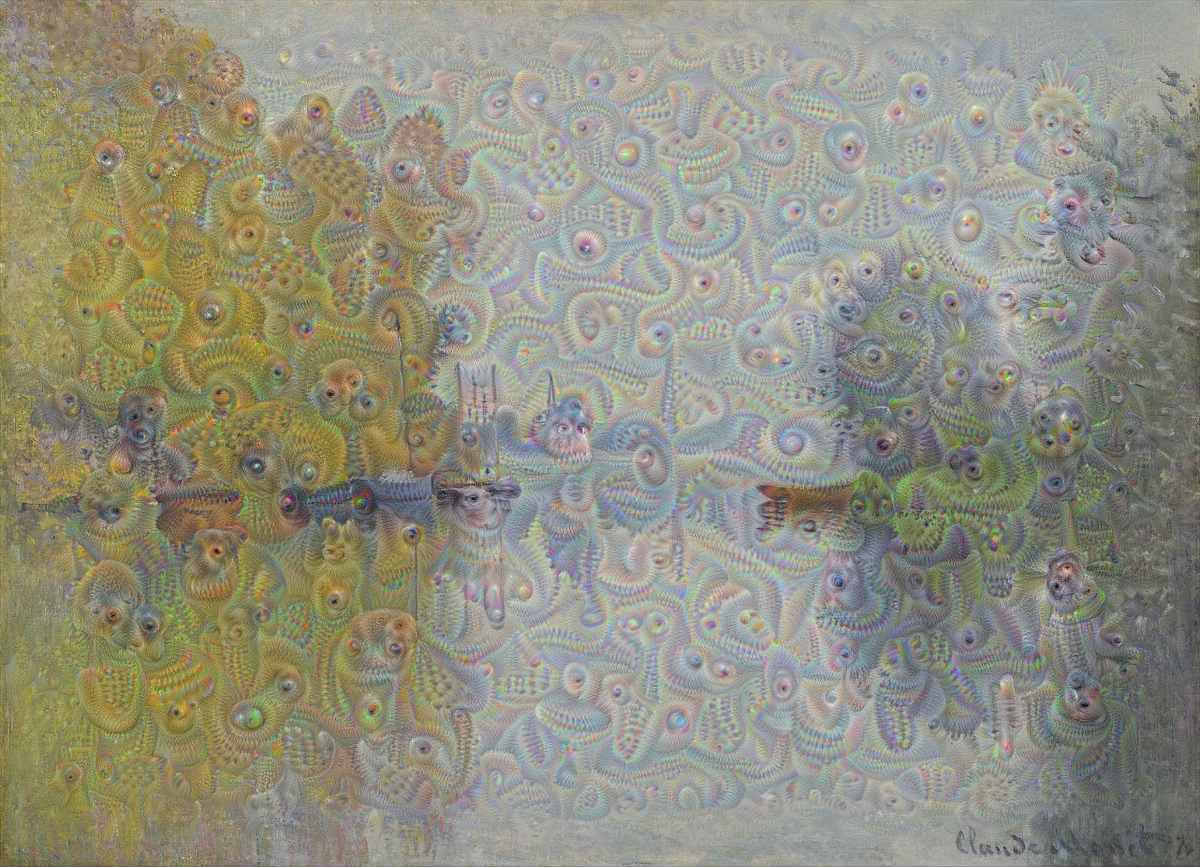

In [88]:
import numpy as np

# Hyperparameters
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales (40%)
iterations = 20  # Number of ascent steps to run between each scale
max_loss = 10  # If the loss grows larger than 10, interrupt the gradient-ascent process to avoid ugly artifacts

#base_image_path = files.upload()
base_image_path = "./Autumn on the Seine.jpg"
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]

# preparing list of shape tuples defining different scale sizes
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i))
    for dim in original_shape])
  successive_shapes.append(shape)

# reversing the order to ascending order
successive_shapes = successive_shapes[::-1]

# resizing the numpy array of the image to the smallest size
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape)  # scale up the dream image
  img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  
  img += lost_detail  # reinjecting lost detail into dream
  shrunk_original_img = resize_img(original_img, shape)
  save_img(img, fname='dream_at_scale_' + str(shape) + '.png')


# Visualize the image (without saving)
import IPython.display
import PIL.Image
img = deprocess_image(np.copy(img))
IPython.display.display(PIL.Image.fromarray(img))

## 8.3 Neural Style Transfer

We will use VGG19 network with the help of Keras to practice neural style transfer. The process is:
1. Set up a network that computes VGG19 layer activations for the style-reference image, the target image, and the generated image at the same time.
2. Use the layer activations computed over these three images to define the loss function described earlier, which you’ll minimize in order to achieve style transfer.
3. Set up a gradient-descent process to minimize this loss function.

In [89]:
# Defining the initial variables
from tensorflow.keras.preprocessing.image import load_img, img_to_array

target_image_path = './keanu_not_smiling-1.jpg'
style_reference_image_path = './Autumn on the Seine.jpg'
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [91]:
# Auxiliary functions
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

# Function to reverse vgg19.preprocess_input
def deprocess_image(x):
  # zero-centering
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [92]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))  # Placeholder that will contain generated image

# Combines the three images into one batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# Builds the VGG19 network with the batch of three images as input
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

print('Model loaded.')

80142336/80134624 [==============================] - 2s 0us/step
Model loaded.


In [93]:
# Content Loss
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

# Style Loss
# Gram matrix is a map of correlations found in the original feature matrix
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# Total Variation Loss
# Regularization loss to avoid overpixelated generated image
def total_variation_loss(x):
  a = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
  
  b = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
  
  return K.sum(K.pow(a + b, 1.25))

In [94]:
# Define the final loss to minimize
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# We will only minimize the last layer for content loss
content_layer = 'block5_conv2'

# For style loss we use all of the layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define loss value by adding contributions to this scalar value
loss = K.variable(0.)

layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

# Adding the content loss
loss = loss + (content_weight * content_loss(target_image_features,
                                      combination_features))

for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss = loss + ((style_weight / len(style_layers)) * sl) # Add the style loss at each target layer

# Add the total variation loss
loss = loss + (total_variation_weight * total_variation_loss(combination_image))

In [95]:
# Gradient descent process
# We will use Scipy's L-BFGS optimization algorithm as shown in Gatys paper

grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
  '''
  This class wraps fetch_loss_and_grads in a way that lets you retrieve the losses and
  gradients via two separate method calls, which is
  required by the SciPy optimizer you'll use.
  '''

  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator = Evaluator()

In [98]:
from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite
import time

result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path) # Initial target image
x = x.flatten() # Scipy L-BFGS can only take flat vector

for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                   x,
                                   fprime=evaluator.grads,
                                   maxfun=20)
  print('Current loss value:', min_val)
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  imwrite(fname, img)
  print('Image saved as', fname)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 422275650.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 5s
Start of iteration 1
Current loss value: 177638030.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 118369230.0
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 86312980.0
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 68081560.0
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 56912876.0
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 48217764.0
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 41887990.0
Image saved as my_result_at_iteration_7.png
Iteration 7 completed in 2s
Start

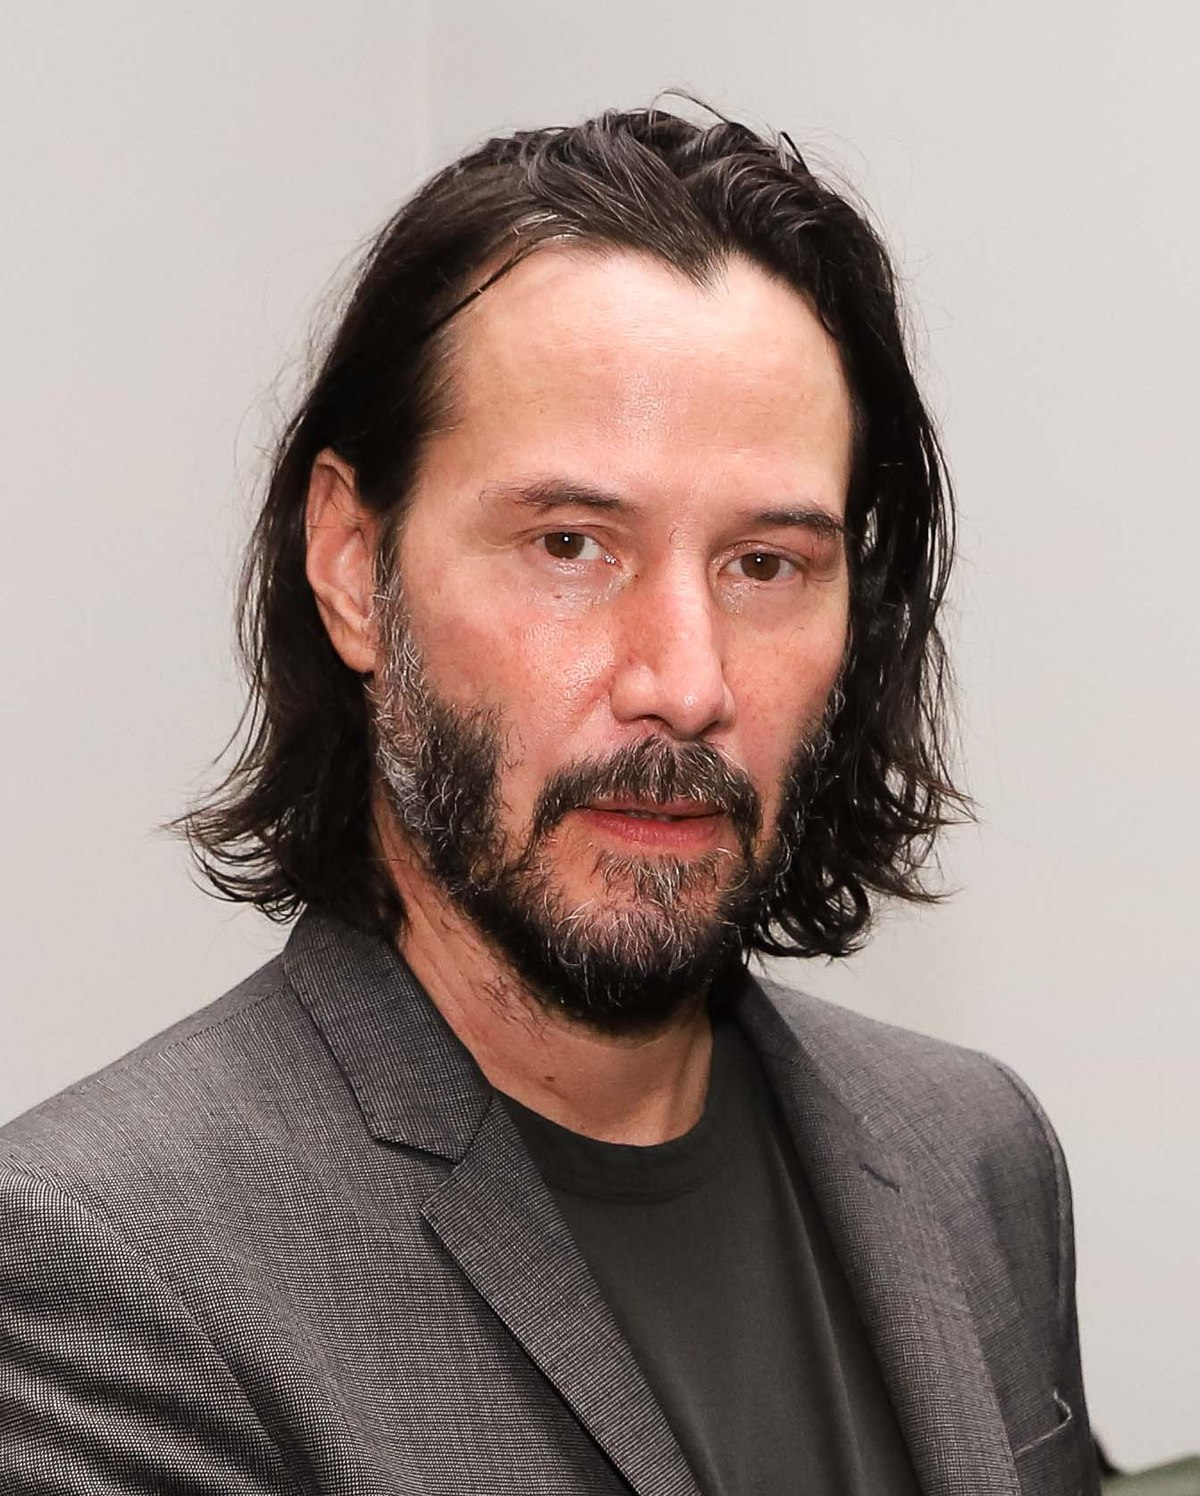

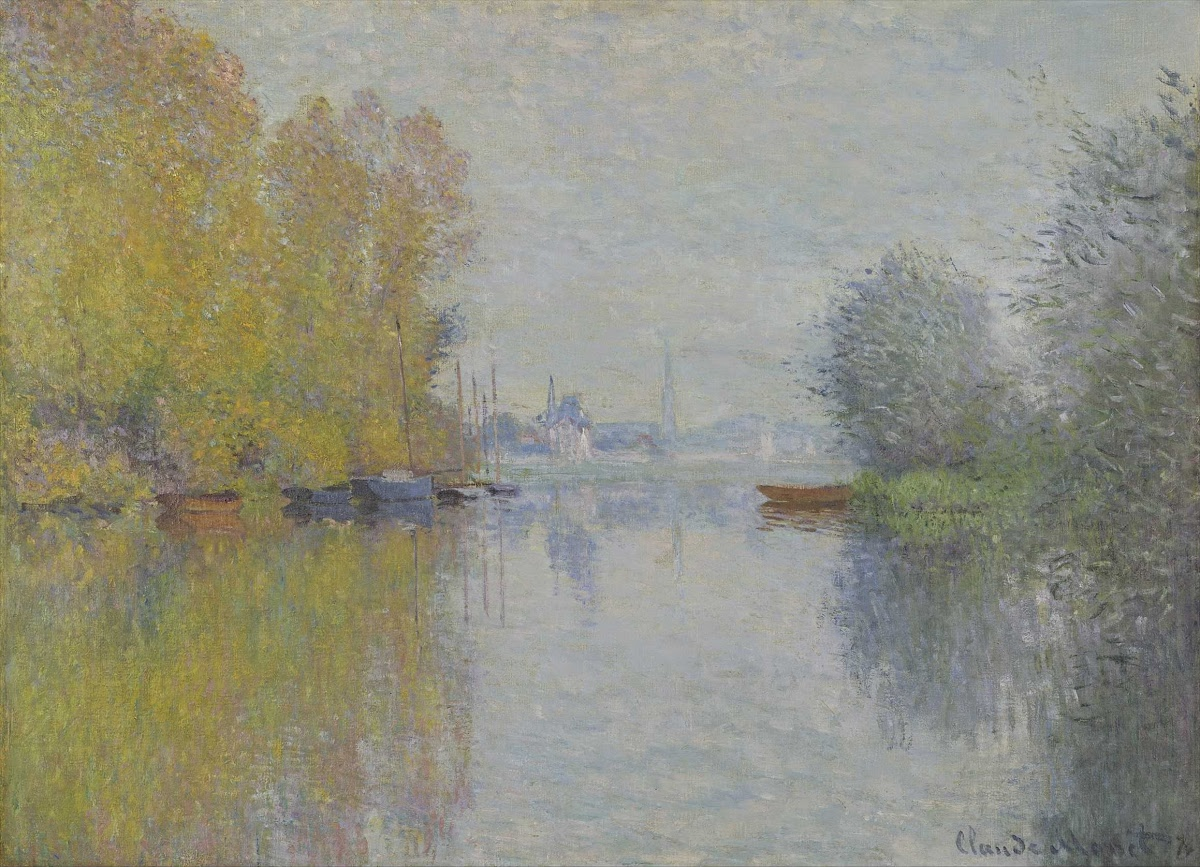

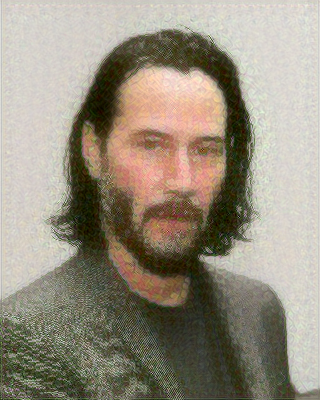

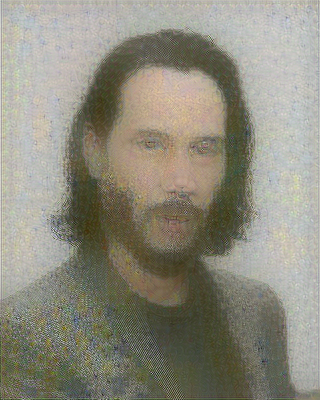

In [110]:
# Visualizing the image generated
from IPython.display import Image
from IPython.display import display

orig = Image(filename='keanu_not_smiling-1.jpg', width=300) 
target = Image(filename='Autumn on the Seine.jpg', width=300) 
generated_1 = Image(filename='my_result_at_iteration_0.png')
generated_final = Image(filename='my_result_at_iteration_19.png') 

display(orig, target, generated_1, generated_final)